# Performance Estimation of multi-class 2D Segmentation

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>
[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/estim_seg2d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1QXv_1ma680dDFh2jpos3NxirXyeku7bt#scrollTo=8ba3dd68-4dba-4638-9de1-ab7847d24d90)

* In this notebook, we will show how to evaluate the performance of multi-class 2D segmentation tasks.
<br>
* More specifically, we show an example of estimating the performance under domain shifts on Cardiac MRI segmentation (into 4 classes including background, left ventricle (LV), myocardium(MYO) and right ventricle (RV)) based on a 3D U-Net. We will utilize the calculated logits on test dataset acquired with a different scanner.
<br>
* We will calculated model confidence with different confidence scores and varied calibration methods.

In [1]:
!pip install moval
!pip install seaborn
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install nibabel

In [2]:
import os
import gdown
import itertools
import zipfile
import pandas as pd
import numpy as np
import nibabel as nib
import moval
from moval.solvers.utils import ComputMetric
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
print(f"The installed MOVAL verision is {moval.__version__}")

The installed MOVAL verision is 0.1.16


## Load the data

In [4]:
# download the data of cardiac

output = "data_moval_supp.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=1ZlC66MGmPlf05aYYCKBaRT2q5uod8GFk&export=download"
    output = "data_moval_supp.zip"
    gdown.download(url, output, quiet=False)

directory_data = "data_moval_supp"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [5]:
ls

analysis_cls.ipynb    data_moval_supp/      img_cardiac/
analysis_seg2d.ipynb  data_moval_supp.zip   img_cardiac.zip
analysis_seg3d.ipynb  estim_cls.ipynb       img_cifar/
data_moval/           estim_seg2d.ipynb     img_cifar.zip
data_moval.zip        estim_seg3d.ipynb


In [6]:
# now I am playing with cardiac segmentation

Datafile_eval = "data_moval_supp/Cardiacresults/seg-eval.txt"
Imglist_eval = open(Datafile_eval)
Imglist_eval_read = Imglist_eval.read().splitlines()

logits = []
gt = []
for Imgname_eval in Imglist_eval_read:
    #
    caseID = Imgname_eval.split("/")[-2]
    #
    GT_file = f"data_moval_supp/Cardiacresults/GT/1/{caseID}/seg.nii.gz"
    #
    logit_cls0_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls1_prob.nii.gz"
    logit_cls2_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls2_prob.nii.gz"
    logit_cls3_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls3_prob.nii.gz"
    #
    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls2_read = nib.load(logit_cls2_file)
    logit_cls3_read = nib.load(logit_cls3_file)
    #
    logit_cls0      = logit_cls0_read.get_fdata()   # ``(H, W, D)``
    logit_cls1      = logit_cls1_read.get_fdata()
    logit_cls2      = logit_cls2_read.get_fdata()
    logit_cls3      = logit_cls3_read.get_fdata()
    #
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H, W, D)``
    #
    logit_cls = np.stack((logit_cls0, logit_cls1, logit_cls2, logit_cls3))  # ``(d, H, W, D)``
    # only including the slices that contains labels
    for dslice in range(GTimg.shape[2]):
        if np.sum(GTimg[:, :, dslice]) > 0:
            logits.append(logit_cls[:, :, :, dslice])
            gt.append(GTimg[:, :, dslice])

# logits is a list of length ``n``,  each element has ``(d, H, W)``. 
# gt is a list of length ``n``,  each element has ``(H, W)``.
# H and W could differ for different cases.

Datafile_test = "data_moval_supp/Cardiacresults/seg-testA.txt"
Imglist_test = open(Datafile_test)
Imglist_test_read = Imglist_test.read().splitlines()

logits_test = []
gt_test = []
for Imgname_eval in Imglist_test_read:
    caseID = Imgname_eval.split("/")[-2]
    #
    GT_file = f"data_moval_supp/Cardiacresults/GT/2/{caseID}/seg.nii.gz"
    #
    logit_cls0_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls1_prob.nii.gz"
    logit_cls2_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls2_prob.nii.gz"
    logit_cls3_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls3_prob.nii.gz"
    #
    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls2_read = nib.load(logit_cls2_file)
    logit_cls3_read = nib.load(logit_cls3_file)
    #
    logit_cls0      = logit_cls0_read.get_fdata()   # ``(H, W, D)``
    logit_cls1      = logit_cls1_read.get_fdata()
    logit_cls2      = logit_cls2_read.get_fdata()
    logit_cls3      = logit_cls3_read.get_fdata()
    #
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H, W, D)``
    logit_cls = np.stack((logit_cls0, logit_cls1, logit_cls2, logit_cls3))  # ``(d, H, W, D)``
    # only including the slices that contains labels
    for dslice in range(GTimg.shape[2]):
        if np.sum(GTimg[:, :, dslice]) > 0:
            logits_test.append(logit_cls[:, :, :, dslice])
            gt_test.append(GTimg[:, :, dslice])

# logits_test is a list of length ``n``,  each element has ``(d, H, W)``. 
# gt_test is a list of length ``n``,  each element has ``(H, W)``.
# H and W could differ for different cases.

In [7]:
print(f"The validation predictions, ``logits`` are a list of length {len(logits)} each element has approximately {logits[0].shape}")
print(f"The validation labels, ``gt`` are a list of length {len(gt)}, each element has approximately {gt[0].shape}\n")
print(f"The test predictions, ``logits_test`` are a list of length {len(logits_test)} each element has approximately {logits_test[0].shape}")
print(f"The test labels, ``gt_test`` are a list of length {len(gt_test)}, each element has approximately {gt_test[0].shape}")

The validation predictions, ``logits`` are a list of length 156 each element has approximately (4, 210, 257)
The validation labels, ``gt`` are a list of length 156, each element has approximately (210, 257)

The test predictions, ``logits_test`` are a list of length 74 each element has approximately (4, 303, 303)
The test labels, ``gt_test`` are a list of length 74, each element has approximately (303, 303)


In [8]:
import random
random.seed(79)
test_inds = list(range(len(logits)))
random.shuffle(test_inds)
test_inds = test_inds[:100]
#
_logits = []
_gt = []
for test_ind in test_inds:
    _logits.append(logits[test_ind])
    _gt.append(gt[test_ind])
logits = _logits
gt = _gt
#
print(f"The validation predictions, ``logits`` are a list of length {len(logits)} each element has approximately {logits[0].shape}")
print(f"The validation labels, ``gt`` are a list of length {len(gt)}, each element has approximately {gt[0].shape}")

The validation predictions, ``logits`` are a list of length 100 each element has approximately (4, 223, 272)
The validation labels, ``gt`` are a list of length 100, each element has approximately (223, 272)


## MOVAL estimataion

In [9]:
moval_options = list(itertools.product(moval.models.get_estim_options(),
                               ["segmentation"],
                               moval.models.get_conf_options(),
                               [False, True]))

In [10]:
# ac-model does not need class-speicfic variants
for moval_option in moval_options:
    if moval_option[0] == 'ac-model' and moval_option[-1] == True:
        moval_options.remove(moval_option)

In [11]:
print(f"The number of moval options is {len(moval_options)}")

The number of moval options is 36


In [12]:
def test_cls(estim_algorithm, mode, confidence_scores, class_specific, logits, gt, logits_tests, gt_tests):
    """Test MOVAL with different conditions for segmentation tasks
        
    Args:
        mode (str): The given task to estimate model performance.
        confidence_scores (str):
            The method to calculate the confidence scores. We provide a list of confidence score calculation methods which 
            can be displayed by running :py:func:`moval.models.get_conf_options`.
        estim_algorithm (str):
            The algorithm to estimate model performance. We also provide a list of estimation algorithm which can be displayed by
            running :py:func:`moval.models.get_estim_options`.
        class_specific (bool):
            If ``True``, the calculation will match class-wise confidence to class-wise accuracy.
        logits: The network output (logits) of a list of n ``(d, H, W, (D))`` for segmentation. 
        gt: The cooresponding annotation of a list of n ``(H, W, (D))`` for segmentation.
        logits_tests:  The network testing output (logits) of a list of n' ``(d, H', W', (D'))`` for segmentation. 
        gt_test: The cooresponding testing annotation of a list of n' ``(H', W', (D'))`` for segmentation.

    Returns:
        err_test (float): testing error.
        moval_model: Optimized moval model.

    """
    
    moval_model = moval.MOVAL(
                mode = mode,
                confidence_scores = confidence_scores,
                estim_algorithm = estim_algorithm,
                class_specific = class_specific,
                approximate = True,
                approximate_boundary = 10
                )

    #
    moval_model.fit(logits, gt)

    # save the test err in the result files.
    # the gt_guide for test data is optional
    gt_guide_test = []
    for n_case in range(len(logits_test)):
        gt_case_test     = gt_test[n_case]
        gt_exist_test = []
        for k_cls in range(logit_cls[0].shape[0]):
            gt_exist_test.append(np.sum(gt_case_test == k_cls) > 0)
        gt_guide_test.append(gt_exist_test)
    
    estim_dsc_test = moval_model.estimate(logits_test, gt_guide = gt_guide_test)

    DSC_list_test = []
    for n_case in range(len(logits_test)):
        pred_case   = np.argmax(logits_test[n_case], axis = 0) # ``(H', W', (D'))``
        gt_case     = gt_test[n_case] # ``(H', W', (D'))``

        dsc_case = np.zeros(logits_test[n_case].shape[0])
        for kcls in range(1, logits_test[n_case].shape[0]):
            if np.sum(gt_case == kcls) == 0:
                dsc_case[kcls] = -1
            else:
                dsc_case[kcls] = ComputMetric(pred_case == kcls, gt_case == kcls)
        DSC_list_test.append(dsc_case)
        
    # only aggregate the ones which are not -1
    DSC_list_test = np.array(DSC_list_test) # ``(n, d)``
    m_DSC_test = []
    m_DSC_test.append(0.)
    for kcls in range(1, logits_test[n_case].shape[0]):
        m_DSC_test.append(DSC_list_test[:, kcls][DSC_list_test[:,kcls] >= 0].mean())
        
    m_DSC_test = np.array(m_DSC_test)
    err_test = np.abs( m_DSC_test[1:] - estim_dsc_test )

    return err_test, moval_model

In [13]:
err_test_list = []
moval_parameters = []
moval_parameters_ = []

In [14]:
for k_cond in tqdm(range(len(moval_options))):
    
    err_test, moval_model = test_cls(
        estim_algorithm = moval_options[k_cond][0], 
        mode = moval_options[k_cond][1], 
        confidence_scores = moval_options[k_cond][2],
        class_specific = moval_options[k_cond][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
    err_test_list.append(err_test)
    moval_parameters.append(moval_model.model_.param)
    if moval_model.model_.extend_param:
        moval_parameters_.append(moval_model.model_.param_ext)
    else:
        moval_parameters_.append(0.)

  0%|                                                                                                                                                                                                                                                  | 0/36 [00:00<?, ?it/s]

Starting optimizing for model ac-model with confidence max_class_probability-conf, class specific is False.


  3%|██████▌                                                                                                                                                                                                                                   | 1/36 [00:03<01:48,  3.11s/it]

Starting optimizing for model ac-model with confidence energy-conf, class specific is False.


  6%|█████████████                                                                                                                                                                                                                             | 2/36 [00:05<01:36,  2.82s/it]

Starting optimizing for model ac-model with confidence entropy-conf, class specific is False.


  8%|███████████████████▌                                                                                                                                                                                                                      | 3/36 [00:08<01:37,  2.96s/it]

Starting optimizing for model ac-model with confidence doctor-conf, class specific is False.


 11%|██████████████████████████                                                                                                                                                                                                                | 4/36 [00:11<01:36,  3.00s/it]

Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 14%|████████████████████████████████▌                                                                                                                                                                                                         | 5/36 [00:24<03:25,  6.62s/it]

Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 17%|███████████████████████████████████████                                                                                                                                                                                                   | 6/36 [02:59<28:23, 56.77s/it]

Starting optimizing for model ts-model with confidence energy-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 19%|█████████████████████████████████████████████▌                                                                                                                                                                                            | 7/36 [03:18<21:36, 44.71s/it]

Starting optimizing for model ts-model with confidence energy-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 22%|████████████████████████████████████████████████████                                                                                                                                                                                      | 8/36 [04:56<28:42, 61.51s/it]

Starting optimizing for model ts-model with confidence entropy-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                               | 9/36 [05:09<20:50, 46.30s/it]

Starting optimizing for model ts-model with confidence entropy-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 28%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 10/36 [07:48<35:13, 81.30s/it]

Starting optimizing for model ts-model with confidence doctor-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 31%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 11/36 [08:03<25:18, 60.76s/it]

Starting optimizing for model ts-model with confidence doctor-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 33%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 12/36 [11:53<44:52, 112.21s/it]

Starting optimizing for model doc-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 36%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 13/36 [12:03<31:10, 81.34s/it]

Starting optimizing for model doc-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...


/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/moval/models/model.py:288: RuntimeWarning: Mean of empty slice.
  m_estim_dsc.append(estim_dsc_list[:, kcls][estim_dsc_list[:,kcls] >= 0].mean())
/Users/zejuli/opt/anaconda3/envs/moval/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 39%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 14/36 [13:44<32:02, 87.38s/it]

Starting optimizing for model doc-model with confidence energy-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 15/36 [13:53<22:17, 63.67s/it]

Starting optimizing for model doc-model with confidence energy-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 16/36 [15:18<23:23, 70.16s/it]

Starting optimizing for model doc-model with confidence entropy-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 17/36 [15:29<16:34, 52.32s/it]

Starting optimizing for model doc-model with confidence entropy-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 18/36 [17:17<20:40, 68.93s/it]

Starting optimizing for model doc-model with confidence doctor-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 19/36 [17:27<14:30, 51.22s/it]

Starting optimizing for model doc-model with confidence doctor-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 20/36 [19:06<17:31, 65.70s/it]

Starting optimizing for model atc-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 21/36 [19:17<12:18, 49.25s/it]

Starting optimizing for model atc-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 22/36 [21:03<15:30, 66.46s/it]

Starting optimizing for model atc-model with confidence energy-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 23/36 [21:18<11:00, 50.81s/it]

Starting optimizing for model atc-model with confidence energy-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 24/36 [22:48<12:32, 62.72s/it]

Starting optimizing for model atc-model with confidence entropy-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 25/36 [23:00<08:42, 47.51s/it]

Starting optimizing for model atc-model with confidence entropy-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 26/36 [24:50<11:00, 66.05s/it]

Starting optimizing for model atc-model with confidence doctor-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 27/36 [25:01<07:26, 49.65s/it]

Starting optimizing for model atc-model with confidence doctor-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 28/36 [26:45<08:46, 65.81s/it]

Starting optimizing for model ts-atc-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 29/36 [27:06<06:07, 52.47s/it]

Starting optimizing for model ts-atc-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 30/36 [30:51<10:24, 104.13s/it]

Starting optimizing for model ts-atc-model with confidence energy-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 31/36 [31:23<06:53, 82.66s/it]

Starting optimizing for model ts-atc-model with confidence energy-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param_ext, trying more initial states..

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 32/36 [34:49<07:58, 119.50s/it]

Starting optimizing for model ts-atc-model with confidence entropy-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 33/36 [35:11<04:31, 90.52s/it]

Starting optimizing for model ts-atc-model with confidence entropy-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 34/36 [38:53<04:19, 129.89s/it]

Starting optimizing for model ts-atc-model with confidence doctor-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 35/36 [39:16<01:37, 97.86s/it]

Starting optimizing for model ts-atc-model with confidence doctor-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [44:00<00:00, 73.34s/it]


## Compare estimataion results

In [15]:
estim = []
conf = []
err = []
err_mean = []
novel = []
k_option = 0
for moval_option in moval_options:
    for k_cond in range(len(err_test_list[k_option])):
        #
        if moval_option[3] == True:
            estim_cs = 'CS '
        else:
            estim_cs = ''
        #    
        if moval_option[0] == 'ac-model':
            estim.append(estim_cs + 'AC')
        elif moval_option[0] == 'ts-model':
            estim.append(estim_cs + 'TS')
        elif moval_option[0] == 'doc-model':
            estim.append(estim_cs + 'DoC')
        elif moval_option[0] == 'atc-model':
            estim.append(estim_cs + 'ATC')
        else:
            estim.append(estim_cs + 'TS-ATC')
        #
        if moval_option[2] == 'max_class_probability-conf':
            conf.append('MCP')
        elif moval_option[2] == 'energy-conf':
            conf.append('Energy')
        elif moval_option[2] == 'entropy-conf':
            conf.append('Entropy')
        else:
            conf.append('Doctor')
        #
        if moval_option[2] == 'max_class_probability-conf' and moval_option[3] == False:
            novel.append('Existing Methods')
        else:
            novel.append('Provided by MOVAL')
        #
        err.append(err_test_list[k_option][k_cond])
        err_mean.append(np.mean(err_test_list[k_option]))
    k_option += 1

In [16]:
d = {'Estimation Algorithm': estim, 'Confidence Score': conf, 'MAE': err_mean, 'MAE ': err, 'Category': novel}
df = pd.DataFrame(data=d)
#
custom_order = ['AC', 'TS', 'DoC', 'ATC', 'TS-ATC', 'CS TS', 'CS DoC', 'CS ATC', 'CS TS-ATC']
df['Estimation Algorithm'] = pd.Categorical(df['Estimation Algorithm'], categories=custom_order, ordered=True)
df = df.sort_values(by='Estimation Algorithm')
#
custom_order = ['MCP', 'Doctor', 'Entropy', 'Energy']
df['Confidence Score'] = pd.Categorical(df['Confidence Score'], categories=custom_order, ordered=True)
df = df.sort_values(by='Confidence Score')

In [17]:
df.head()

,Estimation Algorithm,Confidence Score,MAE,MAE,Category
0,AC,MCP,0.180960,0.160946,Existing Methods
38,DoC,MCP,0.147394,0.149014,Existing Methods
61,ATC,MCP,0.084708,0.096688,Existing Methods
62,ATC,MCP,0.084708,0.045736,Existing Methods
60,ATC,MCP,0.084708,0.111699,Existing Methods


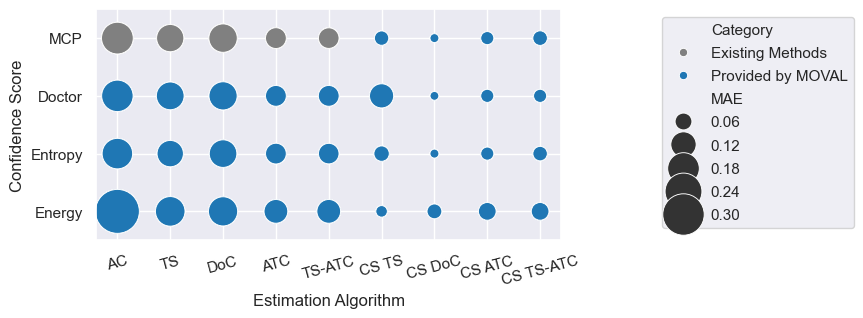

In [18]:
sns.set(rc={'figure.figsize':(6,3)})
sns.set_style("darkgrid")
category_palette = {'Existing Methods': 'grey', 'Provided by MOVAL': '#1f77b4'}
ax = sns.scatterplot(
    data=df, x="Estimation Algorithm", y="Confidence Score", hue="Category", size="MAE",
    sizes=(40, 1000), palette=category_palette
)
ax.set(ylim=(3.5, -0.5))
ax.tick_params(axis='x', rotation=15)
#
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.2, 1), labelspacing = 0.6)
# Increase the line spacing by adjusting position

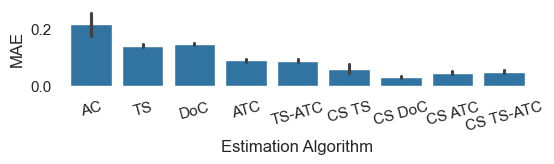

In [19]:
sns.set(rc={'figure.figsize':(6,1)})
sns.set_style("white")
ax = sns.barplot(df, x="Estimation Algorithm", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

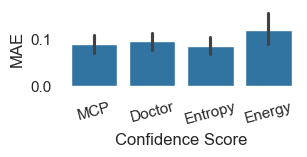

In [20]:
sns.set(rc={'figure.figsize':(3,1)})
sns.set_style("white")
ax = sns.barplot(df, x="Confidence Score", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

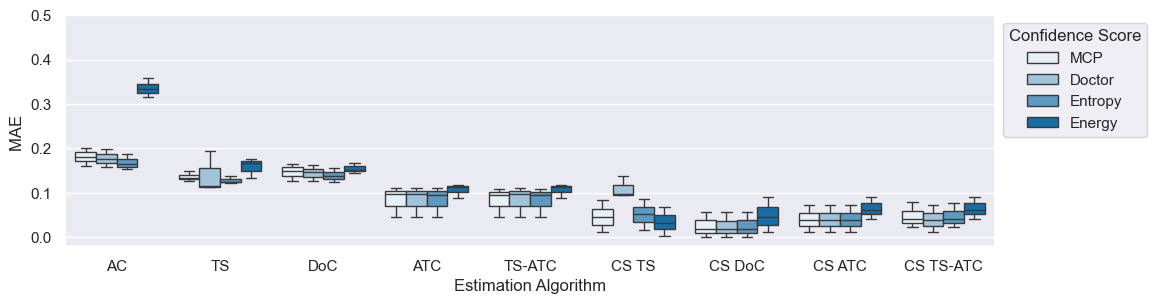

In [21]:
sns.set(rc={'figure.figsize':(12,3)})
category_palette = {'MCP': '#e5f0f8',
                    'Doctor': '#99c6e4',
                    'Entropy': '#4c9cd0',
                    'Energy': '#0072bd'
                   }
ax = sns.boxplot(df, x="Estimation Algorithm", y="MAE ", hue="Confidence Score", palette=category_palette)
ax.set(ylim=(-0.02, 0.5))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))